In [1]:
from pathlib import Path
import sys, os

# 1. cwd is project-root/examples
cwd = Path().resolve()
# 2. project-root is its parent
project_root = cwd.parent

# 3. add project_root to sys.path
sys.path.insert(0, str(project_root))

# debug: make sure 'examples' shows up
# print("PYTHONPATH entries:")
# for p in sys.path[:3]:
#     print(" ", p)
# print("project_root contents:", os.listdir(project_root))

import fire
import numpy as np
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from pytagi import HRCSoftmaxMetric, Utils, exponential_scheduler
from examples.tagi_resnet_model import resnet18_cifar10


In [2]:
torch.manual_seed(17)

# Constants for dataset normalization
NORMALIZATION_MEAN = [0.4914, 0.4822, 0.4465]
NORMALIZATION_STD = [0.2470, 0.2435, 0.2616]

def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images to shape (B*C*H*W,)
    batch_images = batch_images.reshape(-1)

    # Convert to numpy arrays
    batch_images = batch_images.numpy()
    batch_labels = batch_labels.numpy()

    return batch_images, batch_labels


def load_datasets(batch_size: int, framework: str = "tagi"):
    """Load and transform CIFAR10 training and test datasets."""
    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    train_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=True, download=True, transform=transform_train
    )
    test_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=False, download=True, transform=transform_test
    )


    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        collate_fn=custom_collate_fn,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        collate_fn=custom_collate_fn,
    )

    return train_loader, test_loader


In [3]:
images = {}
m_preds = {}
v_preds = {}
v_preds_epistemic = {}
v_preds_aleatoric = {}
y_true = {}



def tagi_trainer(
    num_epochs: int,
    batch_size: int,
    device: str,
    sigma_v: float,
):
    """
    Run classification training on the Cifar dataset using a custom neural model.

    Parameters:
    - num_epochs: int, number of epochs for training
    - batch_size: int, size of the batch for training
    """
    utils = Utils()
    train_loader, test_loader = load_datasets(batch_size, "tagi")

    # Hierachical Softmax
    metric = HRCSoftmaxMetric(num_classes=10)
    nb_classes = 10

    # Resnet18
    net = resnet18_cifar10(gain_w=0.083, gain_b=0.083)
    net.to_device(device)

    epoch = 1
    count = 0

    net.load("../models_bin/cifar_resnet_50_logits_04_165.bin")

    # Testing
    test_error = 0
    num_test_samples = 0
    net.eval()
    for x, labels in test_loader:
        x = x.flatten()
        m_pred, v_pred = net(x)

        print(f"m_pred" f"{m_pred}")
        print(f"v_pred" f"{v_pred}")

        v_pred_epi = v_pred[::2]
        v_pred_ale = m_pred[1::2]
        v_pred = v_pred[::2] + m_pred[1::2]
        m_pred = m_pred[::2]

        for i in range(len(labels)):
            images[count] = x[i * 1024 * 3 : (i + 1) * 1024 * 3]
            m_preds[count] = m_pred[i * 10 : (i + 1) * 10]
            v_preds[count] = v_pred[i * 10 : (i + 1) * 10]
            v_preds_epistemic[count] = v_pred_epi[i * 10 : (i + 1) * 10]
            v_preds_aleatoric[count] = v_pred_ale[i * 10 : (i + 1) * 10]
            y_true[count] = labels[i]
            count += 1


        # Calculate test error
        pred = np.reshape(m_pred, (len(labels), 10))
        label = np.argmax(pred, axis=1)
        test_error += np.sum(label != labels)
        num_test_samples += len(labels)

    test_error_rate = (test_error / num_test_samples) * 100
    print(
        f"\nEpoch {epoch+1}/{num_epochs}: "
        f"Test Error: {test_error_rate:.2f}%"
    )


In [4]:
framework = "tagi"
batch_size = 128
epochs = 50
device = "cuda"
sigma_v = 0.05


tagi_trainer(
    batch_size=batch_size, num_epochs=epochs, device=device, sigma_v=sigma_v
)

Files already downloaded and verified
Files already downloaded and verified
m_pred[-0.53284305  0.35511172 -0.48602796 ...  0.28060818 -1.0108428
  0.86512846]
v_pred[2.39161978e-04 1.88346021e-04 2.12223938e-04 ... 6.15295139e-05
 1.20098375e-04 6.08760747e-04]
m_pred[-0.14812326  0.14561799 -0.2930923  ...  0.10366514 -0.878118
  0.05746987]
v_pred[1.5255253e-04 1.7949800e-05 1.3826760e-04 ... 1.0153824e-05 1.6314730e-04
 3.4257821e-06]
m_pred[-0.13657767  0.3747146  -0.36493832 ...  0.5233915  -0.78229296
  6.7478747 ]
v_pred[0.00151824 0.00095025 0.00129261 ... 0.00031595 0.00059617 0.06660222]
m_pred[-0.36193737  0.08699117 -0.22108054 ...  0.13797532 -0.38327223
  0.08319172]
v_pred[1.3198552e-04 5.8483915e-06 9.5015559e-05 ... 2.8721650e-05 1.8586962e-04
 1.0534819e-05]
m_pred[-0.8794612   0.6731666  -0.28183308 ...  0.18828712 -0.7052732
  0.2183965 ]
v_pred[9.0932124e-04 3.1321917e-03 7.4569217e-04 ... 3.0314621e-05 1.2239438e-04
 4.1211610e-05]
m_pred[-0.2795823   0.07834796 

In [5]:
from scipy.stats import lognorm, norm

# REMAX
def remax(m_preds, v_preds):
    """
    Compute the remax values for the given mean and variance predictions.

    Parameters:
    - m_preds: np.ndarray, mean predictions
    - v_preds: np.ndarray, variance predictions

    Returns:
    - mA: np.ndarray, remax values
    """
    mZ = np.minimum(np.maximum(m_preds, -100), 100)
    s2Z = np.minimum(np.maximum(v_preds, 1E-20), 100)
    sZ = np.sqrt(s2Z)

    # mReLU activation
    cdfn = np.maximum(1E-20, norm.cdf(mZ / sZ))
    pdfn = np.maximum(1E-20, norm.pdf(mZ / sZ))

    mM = np.maximum(1E-20, sZ * pdfn + mZ * cdfn)
    s2M = np.maximum(1E-6, -mM * mM + 2 * mM * mZ - mZ * sZ * pdfn + (s2Z - mZ * mZ) * cdfn)
    sM = np.sqrt(s2M)
    cov_ZM = s2Z * cdfn

    # lnM = log(M_i)
    s2lnM = np.log(1 + np.minimum(10, s2M / mM**2))
    slnM = np.sqrt(s2lnM)
    mlnM = np.log(mM) - 0.5 * s2lnM
    cov_M_lnM = s2lnM * mM

    # \tilde{M} = sum(M_i)
    mM_sum = np.sum(mM)
    s2M_sum = np.sum(s2M)
    sM_sum = np.sqrt(s2M_sum)
    cov_M_M_sum = s2M  # / np.sqrt(2)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! TEST

    # ln\tilde{M} = log(\tilde{M}_i)
    s2lnM_sum = np.log(1 + s2M_sum / mM_sum**2)
    slnM_sum = np.sqrt(s2lnM_sum)
    mlnM_sum = np.log(mM_sum) - 0.5 * s2lnM_sum
    cov_lnM_lnM_sum = np.log(1 + cov_M_M_sum / mM / mM_sum)

    # 1/\tilde{M} -> 1-ln\tilde{M}
    s2lnM_sum_inv = s2lnM_sum
    mlnM_sum_inv = 1 - mlnM_sum
    mM_sum_inv = np.exp(mlnM_sum_inv + 0.5 * s2lnM_sum_inv)
    s2M_sum_inv = mM_sum_inv**2 * (np.exp(s2lnM_sum_inv) - 1)
    cov_M_M_sum_inv = (np.exp(cov_lnM_lnM_sum) - 1) * mM_sum * mM_sum_inv

    # \check{A}_i = lnM_i - ln\tilde{M}
    mlnA = mlnM - mlnM_sum
    s2lnA = np.maximum(s2lnM + s2lnM_sum - 2 * cov_lnM_lnM_sum, 1E-6)
    slnA = np.sqrt(s2lnA)
    cov_cAlnM = s2lnM - cov_lnM_lnM_sum
    cov_cAlnM_sum = cov_lnM_lnM_sum - s2lnM_sum
    cov_cAMj = cov_cAlnM_sum * mM_sum / s2M_sum * s2M[0]

    # A_i = normal
    mA = np.exp(mlnA + 1 / 2 * s2lnA)
    mA = mA / np.sum(mA)
    s2A = mA**2 * (np.exp(s2lnA) - 1)
    sA = np.sqrt(s2A)

    return mA, s2A





m_preds: [-0.2831278  11.588242   -0.04156208 -0.45919994 -1.1580082  -1.0874252
  0.1346747  -0.44059047  0.26056144  3.142967  ]
v_preds: [ 0.17068131 11.77963     0.32162344  0.06706668  0.21369027  1.7365292
  0.93501467  0.07333198  0.14088498 29.685898  ]
m_preds_softmax: [1.0688989e-07 5.3271908e-08 3.7159438e-08 9.9999940e-01 6.5245587e-08
 3.3670403e-08 4.9506404e-08 1.2942846e-07 1.2706145e-07 5.6405284e-08]


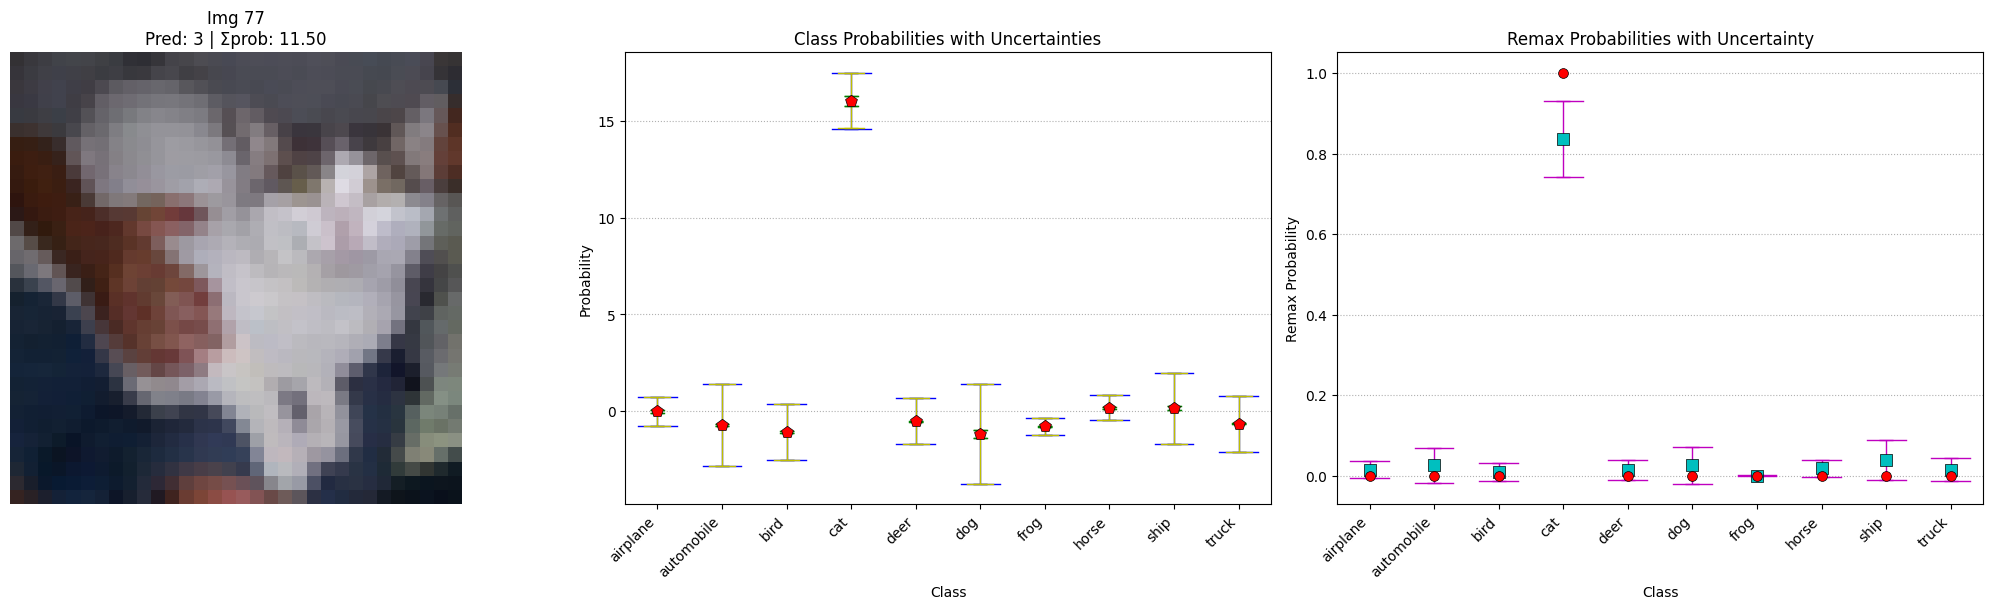

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_class_uncertainty(image_idx, images, m_preds, v_preds, v_preds_epistemic, v_preds_aleatoric, delta=0.3):
    """
    Plots CIFAR-10 images with class probabilities, uncertainties, and Remax probabilities.
    """
    # 1. Fix image preprocessing for CIFAR-10
    img = images[image_idx]
    img = img.reshape(3, 32, 32).transpose(1, 2, 0)

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Denormalize if using standard CIFAR normalization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Ensure valid pixel range

    # 2. Handle probabilistic outputs
    means = m_preds[image_idx]
    stds = np.sqrt(v_preds[image_idx])
    stds_epistemic = np.sqrt(v_preds_epistemic[image_idx])
    stds_aleatoric = np.sqrt(v_preds_aleatoric[image_idx])
    classes = np.arange(10)

    # 3. Compute Remax values
    mA, s2A = remax(means, v_preds[image_idx])
    sA = np.sqrt(s2A)

    # 3.5. Deterministic softmax on m_preds
    m_preds_softmax = nn.Softmax(dim=0)(torch.tensor(means)).numpy()

    print("m_preds_softmax:", m_preds_softmax)

    # 4. Create figure with three subplots
    fig, (ax_img, ax_probs, ax_remax) = plt.subplots(1, 3, figsize=(21, 6))

    # Image plot (CIFAR-10 specific)
    ax_img.imshow(img)
    ax_img.set_title(f'Img {image_idx}\nPred: {np.argmax(means)} | Σprob: {np.sum(means):.2f}')
    ax_img.axis('off')

    # Probability plot with error bars
    for i in classes:
        # Total uncertainty (blue)
        ax_probs.errorbar(i, means[i], yerr=stds[i], fmt='none', ecolor='b',
                          elinewidth=1, capsize=5)
        ax_probs.plot([i-0.3, i+0.3], [means[i]+stds[i], means[i]+stds[i]], 'b', linewidth=1)
        ax_probs.plot([i-0.3, i+0.3], [means[i]-stds[i], means[i]-stds[i]], 'b', linewidth=1)

        # Aleatoric uncertainty (yellow)
        ax_probs.errorbar(i, means[i], yerr=stds_aleatoric[i], fmt='none',
                         ecolor='y', elinewidth=1, capsize=5)
        ax_probs.plot([i-0.2, i+0.2], [means[i]+stds_aleatoric[i], means[i]+stds_aleatoric[i]], 'y', linewidth=1)
        ax_probs.plot([i-0.2, i+0.2], [means[i]-stds_aleatoric[i], means[i]-stds_aleatoric[i]], 'y', linewidth=1)

        # Epistemic uncertainty (green)
        ax_probs.errorbar(i, means[i], yerr=stds_epistemic[i], fmt='none',
                         ecolor='g', elinewidth=1, capsize=5)
        ax_probs.plot([i-0.1, i+0.1], [means[i]+stds_epistemic[i], means[i]+stds_epistemic[i]], 'g', linewidth=1)
        ax_probs.plot([i-0.1, i+0.1], [means[i]-stds_epistemic[i], means[i]-stds_epistemic[i]], 'g', linewidth=1)

        ax_probs.scatter(i, means[i], color='r', marker='p', s=80,
                        zorder=3, edgecolor='k', linewidth=0.5)

    # Probability plot formatting
    ax_probs.set_xticks(classes)
    ax_probs.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
    ax_probs.set_xlim(-0.5, 9.5)
    ax_probs.grid(True, axis='y', linestyle=':')
    ax_probs.set_xlabel('Class')
    ax_probs.set_ylabel('Probability')
    ax_probs.set_title('Class Probabilities with Uncertainties')

    # Probability plot legend
    prob_legend = [
        Line2D([0], [0], marker='p', color='w', label='Probability',
              markerfacecolor='r', markersize=10),
        Line2D([0], [0], color='b', lw=2, label='μ ± σ_total'),
        Line2D([0], [0], color='g', lw=2, label='μ ± σ_epistemic'),
        Line2D([0], [0], color='y', lw=2, label='μ ± σ_aleatoric')
    ]
    # ax_probs.legend(handles=prob_legend, loc='upper right')

    # Remax probability plot
    for i in classes:
        # Remax uncertainty (magenta)
        ax_remax.errorbar(i, mA[i], yerr=sA[i], fmt='none', ecolor='m',
                         elinewidth=1, capsize=5)
        ax_remax.plot([i-0.3, i+0.3], [mA[i]+sA[i], mA[i]+sA[i]], 'm', linewidth=1)
        ax_remax.plot([i-0.3, i+0.3], [mA[i]-sA[i], mA[i]-sA[i]], 'm', linewidth=1)
        ax_remax.scatter(i, mA[i], color='c', marker='s', s=80,
                        zorder=3, edgecolor='k', linewidth=0.5)

        # Include softmax probabilities with a red dot
        ax_remax.scatter(i, m_preds_softmax[i], color='r', marker='o', s=50,
                        zorder=4, edgecolor='k', linewidth=0.5)

    # Remax plot formatting
    ax_remax.set_xticks(classes)
    ax_remax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
    ax_remax.set_xlim(-0.5, 9.5)
    ax_remax.grid(True, axis='y', linestyle=':')
    ax_remax.set_xlabel('Class')
    ax_remax.set_ylabel('Remax Probability')
    ax_remax.set_title('Remax Probabilities with Uncertainty')

    # Remax plot legend
    remax_legend = [
        Line2D([0], [0], marker='s', color='w', label='Remax μ',
              markerfacecolor='c', markersize=10),
        Line2D([0], [0], color='m', lw=2, label='μ ± σ_remax')
    ]
    # ax_remax.legend(handles=remax_legend, loc='upper right')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()


# Sort the images by their aleatoric uncertainty
sorted_indices = np.argsort([v_preds_aleatoric[i][0] for i in range(len(v_preds_aleatoric))])
top_5_indices = sorted_indices[-100:]

print("m_preds:", m_preds[6])
print("v_preds:", v_preds[6])

plot_class_uncertainty(77, images, m_preds, v_preds, v_preds_epistemic, v_preds_aleatoric)
# for i in top_5_indices:
#     plot_class_uncertainty(i, images, m_preds, v_preds, v_preds_epistemic, v_preds_aleatoric)

In [7]:
mA = {}
s2A = {}
def compute_remax_for_all(m_preds, v_preds):
    """
    Compute the remax values for all images.

    Parameters:
    - m_preds: dict, mean predictions for all images
    - v_preds: dict, variance predictions for all images

    Returns:
    - mA: dict, remax values for all images
    - s2A: dict, variance of remax values for all images
    """
    mA = {}
    s2A = {}

    for i in range(len(m_preds)):
        # mA[i], s2A[i] = remax(m_preds[i], v_preds[i])
        # Deterministic remax mReLU(Z_i)/ sum(mReLU(Z_i))
        sum_mRelu = np.sum(np.maximum(0, m_preds[i]))
        mA[i] = np.maximum(0, m_preds[i]) / sum_mRelu
        s2A[i] = np.maximum(1E-6, v_preds[i]) / (sum_mRelu**2)

    return mA, s2A

# Precompute Remax outputs
mA, s2A = compute_remax_for_all(m_preds, v_preds)

## Experiment: Mean vs. Variance Relationship


### **1. Scatter Plot: Mean vs. Variance**
- **Metrics**:  
  Pearson (linear):  
 $$
  r = \frac{\text{cov}(μ, σ^2)}{σ_{μ} \cdot σ_{σ^2}}
  $$  
  Spearman (monotonic):  
 $$
  ρ = \frac{\text{cov}(\text{rank}(μ), \text{rank}(σ^2))}{σ_{\text{rank}(μ)} \cdot σ_{\text{rank}(σ^2)}}
  $$  
- **Purpose**: Shows if confident predictions (high mean) have low variance (negative correlation).

---

### **2. Bar Plot: Class-Wise Spearman**  
- **Formula**: Same Spearman \(ρ\) computed **per class** (e.g., only "cat" predictions).  
- **Purpose**: Identifies classes where variance adds unique information (weak correlation) vs. redundancy (strong negative \(ρ\)).  

/tmp/ipykernel_3024844/3112495948.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(class_names, rotation=45, ha='right')


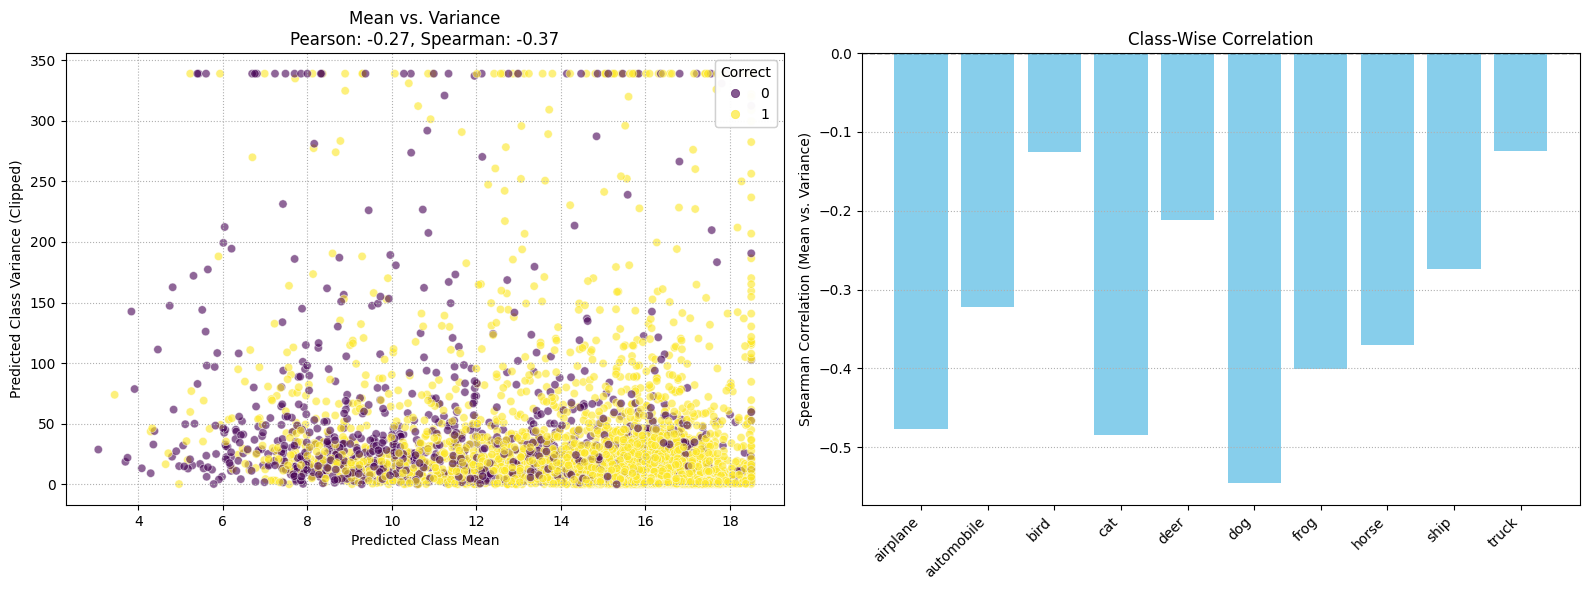

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

def mean_vs_variance_analysis(
    m_preds_dict,
    v_preds_dict,
    y_true_dict,
    class_names,
    clip_var_percentile=99  # Clip extreme variances for visualization
):
    # Convert dictionaries to numpy arrays
    m_preds = np.stack([m_preds_dict[i] for i in m_preds_dict.keys()])
    v_preds = np.stack([v_preds_dict[i] for i in v_preds_dict.keys()])
    y_true = np.array([y_true_dict[i] for i in y_true_dict.keys()])

    # Get predicted classes and their mean/variance
    pred_classes = np.argmax(m_preds, axis=1)
    pred_means = m_preds[np.arange(len(pred_classes)), pred_classes]
    pred_vars = v_preds[np.arange(len(pred_classes)), pred_classes]

    # Clip extreme means (optional)
    mean_cap = np.percentile(pred_means, clip_var_percentile)
    pred_means_clipped = np.clip(pred_means, None, mean_cap)

    # Clip extreme variances (optional)
    var_cap = np.percentile(pred_vars, clip_var_percentile)
    pred_vars_clipped = np.clip(pred_vars, None, var_cap)

    # Split into correct/incorrect
    correct_mask = (pred_classes == y_true)

    # Compute correlations
    corr_pearson, p_pearson = pearsonr(pred_means_clipped, pred_vars_clipped)
    corr_spearman, p_spearman = spearmanr(pred_means_clipped, pred_vars_clipped)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Scatter plot: Mean vs. Variance (colored by correctness)
    scatter = ax[0].scatter(
        pred_means_clipped,
        pred_vars_clipped,
        c=correct_mask,
        cmap='viridis',
        alpha=0.6,
        edgecolors='w',
        linewidths=0.5
    )
    ax[0].set_xlabel('Predicted Class Mean')
    ax[0].set_ylabel('Predicted Class Variance (Clipped)')
    ax[0].set_title(f'Mean vs. Variance\nPearson: {corr_pearson:.2f}, Spearman: {corr_spearman:.2f}')
    ax[0].grid(True, linestyle=':')

    # Legend for correctness
    legend = ax[0].legend(*scatter.legend_elements(), title="Correct", loc='upper right')
    ax[0].add_artist(legend)

    # Class-wise analysis
    class_corrs = []
    for cls in range(10):
        cls_mask = (pred_classes == cls)
        if np.sum(cls_mask) < 10:  # Skip classes with too few samples
            class_corrs.append(np.nan)
            continue
        corr, _ = spearmanr(
            m_preds[cls_mask, cls],
            v_preds[cls_mask, cls]
        )
        class_corrs.append(corr)

    # Bar plot: Class-wise correlations
    ax[1].bar(class_names, class_corrs, color='skyblue')
    ax[1].axhline(0, color='k', linestyle='--', linewidth=1)
    ax[1].set_xticklabels(class_names, rotation=45, ha='right')
    ax[1].set_ylabel('Spearman Correlation (Mean vs. Variance)')
    ax[1].set_title('Class-Wise Correlation')
    ax[1].grid(True, axis='y', linestyle=':')

    plt.tight_layout()
    plt.show()

# Usage
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
mean_vs_variance_analysis(m_preds, v_preds, y_true, class_names)

/tmp/ipykernel_3024844/3112495948.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(class_names, rotation=45, ha='right')


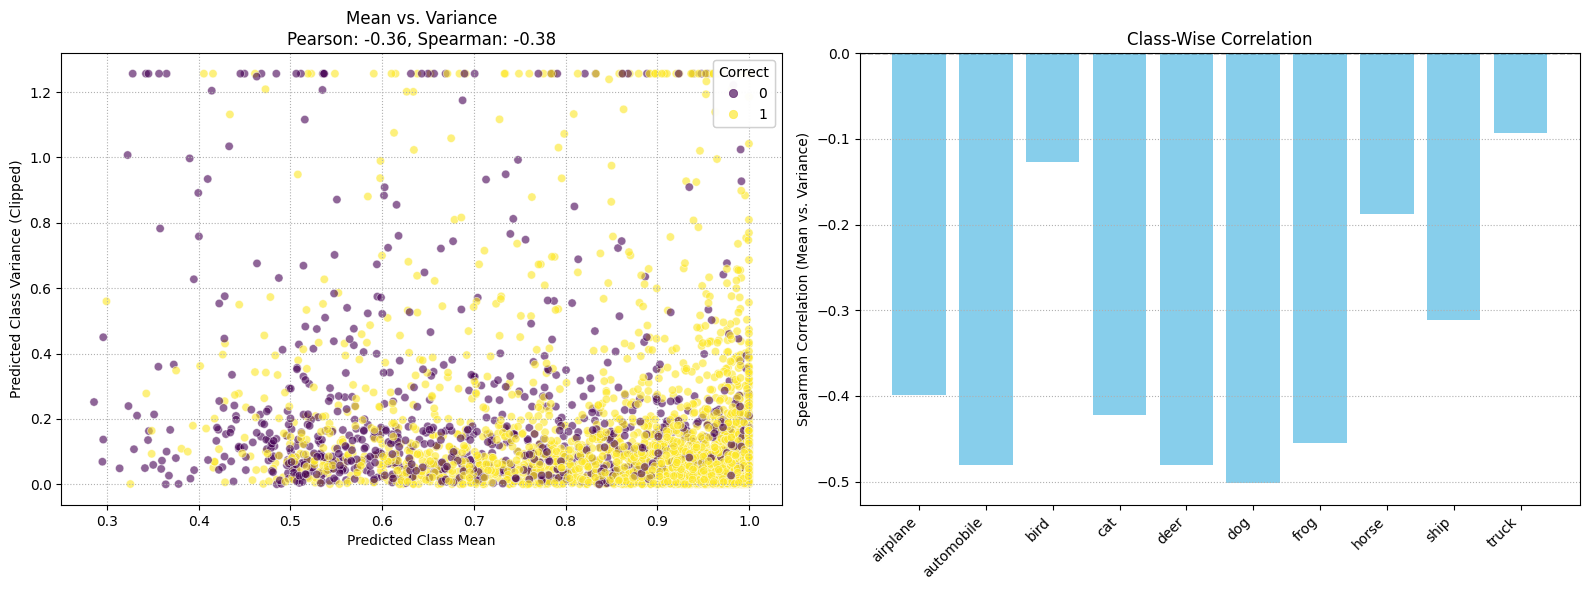

In [9]:
mean_vs_variance_analysis(mA, s2A, y_true, class_names)

## Experiment 1: Predicted Class Variance in Correct vs. Incorrect

/tmp/ipykernel_3024844/2325348671.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(
/tmp/ipykernel_3024844/2325348671.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(
/tmp/ipykernel_3024844/2325348671.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(


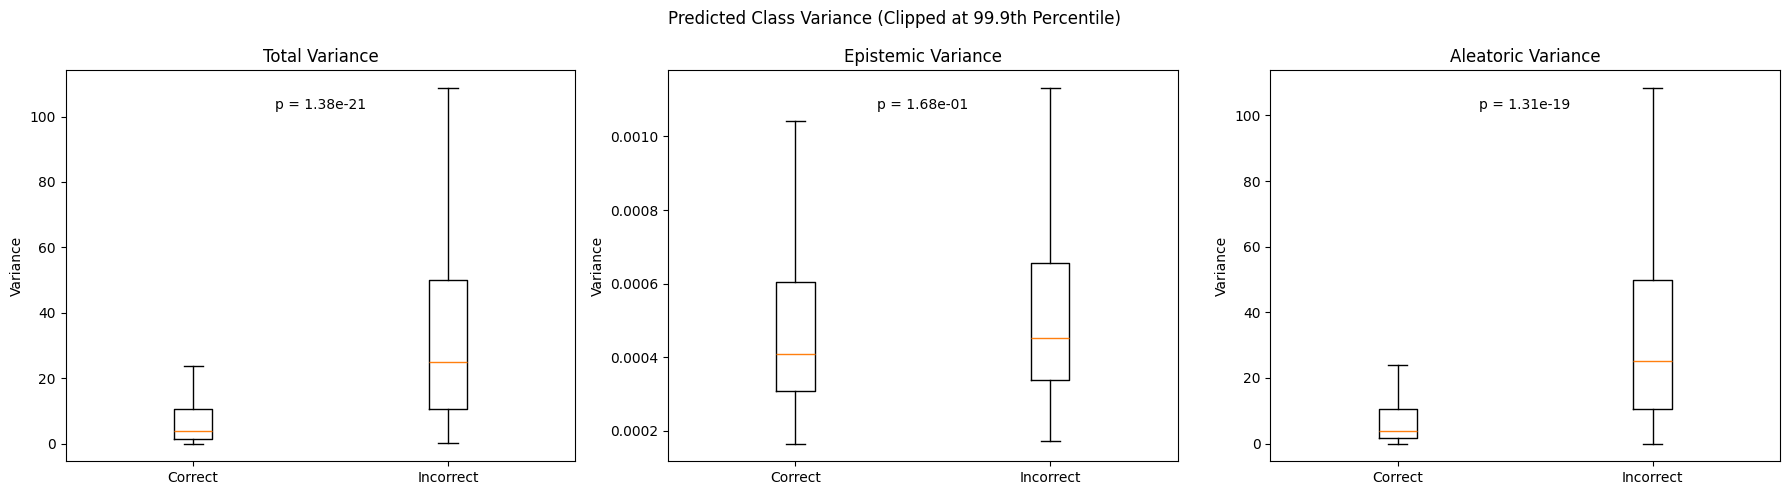

In [10]:
# import ttest_ind
from scipy.stats import ttest_ind

def analyze_correct_vs_incorrect(
    y_true_dict,
    m_preds_dict,
    v_preds_dict,
    v_epistemic_dict,
    v_aleatoric_dict,
    clip_percentile=99.9  # Adjust this threshold (e.g., 99, 99.5, 99.9)
):
    # Convert dictionaries to numpy arrays
    y_true = np.array([y_true_dict[i] for i in y_true_dict.keys()])
    m_preds = np.stack([m_preds_dict[i] for i in m_preds_dict.keys()])
    v_preds = np.stack([v_preds_dict[i] for i in v_preds_dict.keys()])
    v_epistemic = np.stack([v_epistemic_dict[i] for i in v_epistemic_dict.keys()])
    v_aleatoric = np.stack([v_aleatoric_dict[i] for i in v_aleatoric_dict.keys()])


    # Predicted classes
    pred_classes = np.argmax(m_preds, axis=1)
    correct_mask = (pred_classes == y_true)

    # Extract variances for predicted class
    total_var = v_preds[np.arange(len(pred_classes)), pred_classes]
    epistemic_var = v_epistemic[np.arange(len(pred_classes)), pred_classes]
    aleatoric_var = v_aleatoric[np.arange(len(pred_classes)), pred_classes]

    # Split into correct/incorrect
    correct_vars = {
        'total': total_var[correct_mask],
        'epistemic': epistemic_var[correct_mask],
        'aleatoric': aleatoric_var[correct_mask]
    }
    incorrect_vars = {
        'total': total_var[~correct_mask],
        'epistemic': epistemic_var[~correct_mask],
        'aleatoric': aleatoric_var[~correct_mask]
    }

    # Remove outliers by clipping to percentile
    for var_type in ['total', 'epistemic', 'aleatoric']:
        # Compute percentile threshold across all data (correct + incorrect)
        all_data = np.concatenate([
            correct_vars[var_type],
            incorrect_vars[var_type]
        ])
        cap = np.percentile(all_data, clip_percentile)

        # Clip values above the cap
        correct_vars[var_type] = np.clip(correct_vars[var_type], None, cap)
        incorrect_vars[var_type] = np.clip(incorrect_vars[var_type], None, cap)

    # Plotting (unchanged)
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    types = ['total', 'epistemic', 'aleatoric']
    colors = ['b', 'g', 'y']

    for i, (var_type, color) in enumerate(zip(types, colors)):
        ax[i].boxplot(
            [correct_vars[var_type], incorrect_vars[var_type]],
            labels=['Correct', 'Incorrect'],
            showfliers=False  # Hide remaining outliers after clipping
        )
        ax[i].set_title(f'{var_type.capitalize()} Variance')
        ax[i].set_ylabel('Variance')

        # T-test
        t_stat, p_val = ttest_ind(correct_vars[var_type], incorrect_vars[var_type])
        ax[i].text(0.5, 0.9, f'p = {p_val:.2e}', ha='center', transform=ax[i].transAxes)

    plt.suptitle(f'Predicted Class Variance (Clipped at {clip_percentile}th Percentile)')
    plt.tight_layout()
    plt.show()

# Usage
analyze_correct_vs_incorrect(
    y_true, m_preds, v_preds, v_preds_epistemic, v_preds_aleatoric,
    clip_percentile=99.9  # Adjust this value based on your data
)

/tmp/ipykernel_3024844/3091375385.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(
/tmp/ipykernel_3024844/3091375385.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(
/tmp/ipykernel_3024844/3091375385.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(


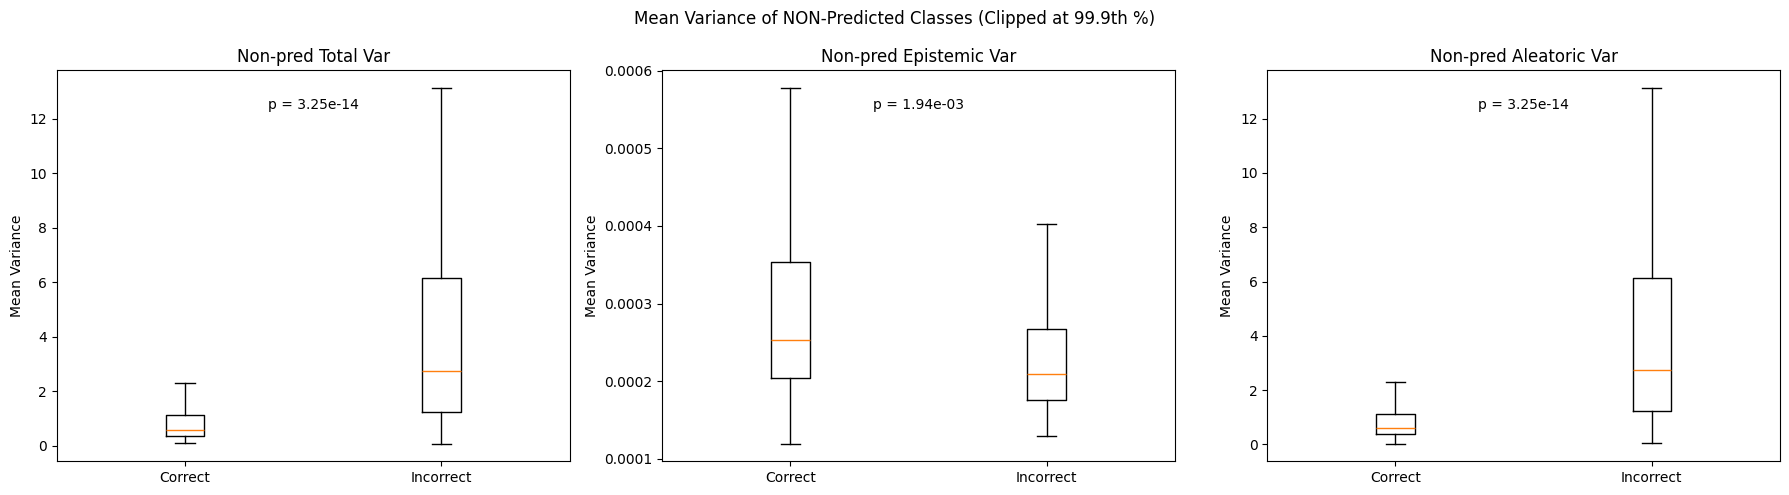

In [11]:
from scipy.stats import ttest_ind

def analyze_correct_vs_incorrect(
    y_true_dict,
    m_preds_dict,
    v_preds_dict,
    v_epistemic_dict,
    v_aleatoric_dict,
    clip_percentile=99.9
):
    # Convert dictionaries to numpy arrays
    y_true = np.array([y_true_dict[i] for i in y_true_dict.keys()])
    m_preds = np.stack([m_preds_dict[i] for i in m_preds_dict.keys()])
    v_preds = np.stack([v_preds_dict[i] for i in v_preds_dict.keys()])
    v_epistemic = np.stack([v_epistemic_dict[i] for i in v_epistemic_dict.keys()])
    v_aleatoric = np.stack([v_aleatoric_dict[i] for i in v_aleatoric_dict.keys()])

    # Predicted classes
    pred_classes = np.argmax(m_preds, axis=1)
    correct_mask = (pred_classes == y_true)

    # NEW: Compute mean variance of NON-predicted classes -----------------------
    def get_non_pred_mean(var_matrix, pred_classes):
        mask = np.ones_like(var_matrix, dtype=bool)
        mask[np.arange(len(pred_classes)), pred_classes] = False
        return np.mean(var_matrix[mask].reshape(len(pred_classes), -1), axis=1)

    total_var = get_non_pred_mean(v_preds, pred_classes)
    epistemic_var = get_non_pred_mean(v_epistemic, pred_classes)
    aleatoric_var = get_non_pred_mean(v_aleatoric, pred_classes)
    # ---------------------------------------------------------------------------

    # Split into correct/incorrect
    correct_vars = {
        'total': total_var[correct_mask],
        'epistemic': epistemic_var[correct_mask],
        'aleatoric': aleatoric_var[correct_mask]
    }
    incorrect_vars = {
        'total': total_var[~correct_mask],
        'epistemic': epistemic_var[~correct_mask],
        'aleatoric': aleatoric_var[~correct_mask]
    }

    # Remove outliers by clipping
    for var_type in ['total', 'epistemic', 'aleatoric']:
        all_data = np.concatenate([correct_vars[var_type], incorrect_vars[var_type]])
        cap = np.percentile(all_data, clip_percentile)
        correct_vars[var_type] = np.clip(correct_vars[var_type], None, cap)
        incorrect_vars[var_type] = np.clip(incorrect_vars[var_type], None, cap)

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    types = ['total', 'epistemic', 'aleatoric']
    colors = ['b', 'g', 'y']

    for i, (var_type, color) in enumerate(zip(types, colors)):
        ax[i].boxplot(
            [correct_vars[var_type], incorrect_vars[var_type]],
            labels=['Correct', 'Incorrect'],
            showfliers=False
        )
        ax[i].set_title(f'Non-pred {var_type.capitalize()} Var')
        ax[i].set_ylabel('Mean Variance')

        t_stat, p_val = ttest_ind(correct_vars[var_type], incorrect_vars[var_type])
        ax[i].text(0.5, 0.9, f'p = {p_val:.2e}', ha='center', transform=ax[i].transAxes)

    plt.suptitle(f'Mean Variance of NON-Predicted Classes (Clipped at {clip_percentile}th %)')
    plt.tight_layout()
    plt.show()

analyze_correct_vs_incorrect(
    y_true, m_preds, v_preds, v_preds_epistemic, v_preds_aleatoric,
    clip_percentile=99.9
)

## 2. Class-Wise Variance vs. Accuracy

Do classes with higher uncertainty (variance) have lower accuracy?
- A negative trend (high variance ↔ low accuracy) suggests uncertainty correlates with model errors.
- A flat/no trend implies variance provides no useful signal about accuracy.

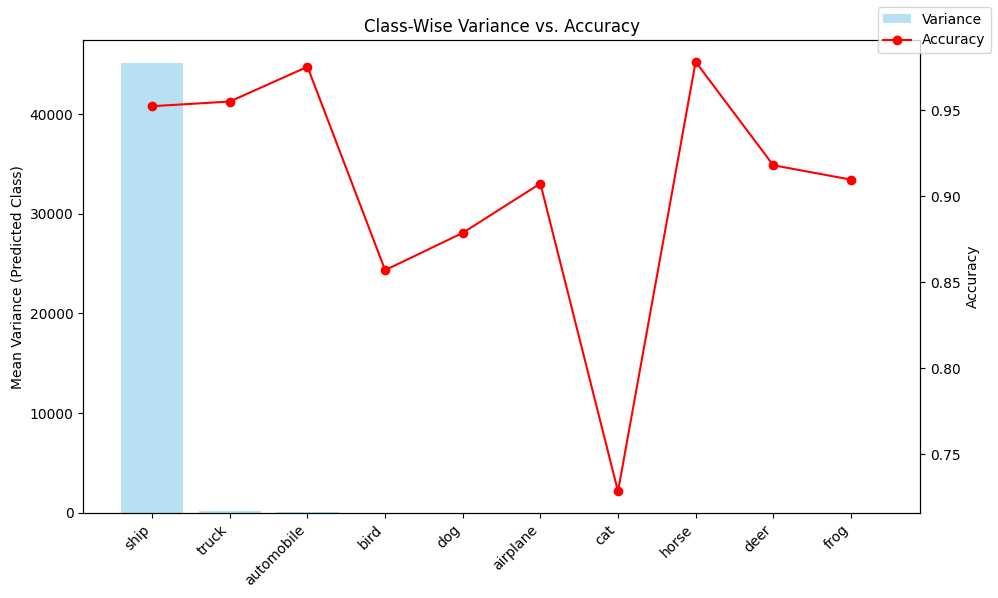

In [12]:
def classwise_variance_accuracy(y_true_dict, m_preds_dict, v_preds_dict, class_names):
    # Convert to numpy arrays
    y_true = np.array([y_true_dict[i] for i in y_true_dict.keys()])
    m_preds = np.stack([m_preds_dict[i] for i in m_preds_dict.keys()])
    v_preds = np.stack([v_preds_dict[i] for i in v_preds_dict.keys()])

    pred_classes = np.argmax(m_preds, axis=1)
    class_acc = []
    class_var = []

    for cls in range(10):
        cls_mask = (pred_classes == cls)
        if np.sum(cls_mask) == 0:
            acc = 0
            var = 0
        else:
            acc = np.mean(y_true[cls_mask] == cls)
            var = np.mean(v_preds[cls_mask, cls])
        class_acc.append(acc)
        class_var.append(var)

    # Sort by variance
    order = np.argsort(class_var)[::-1]
    sorted_names = [class_names[i] for i in order]
    sorted_acc = [class_acc[i] for i in order]
    sorted_var = [class_var[i] for i in order]

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.bar(range(10), sorted_var, color='skyblue', alpha=0.6, label='Variance')
    ax1.set_xticks(range(10))
    ax1.set_xticklabels(sorted_names, rotation=45, ha='right')
    ax1.set_ylabel('Mean Variance (Predicted Class)')

    ax2 = ax1.twinx()
    ax2.plot(range(10), sorted_acc, 'r-o', label='Accuracy')
    ax2.set_ylabel('Accuracy')

    plt.title('Class-Wise Variance vs. Accuracy')
    fig.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Usage
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
classwise_variance_accuracy(y_true, m_preds, v_preds, class_names)

## 3. Cross-Class Variance Relationships

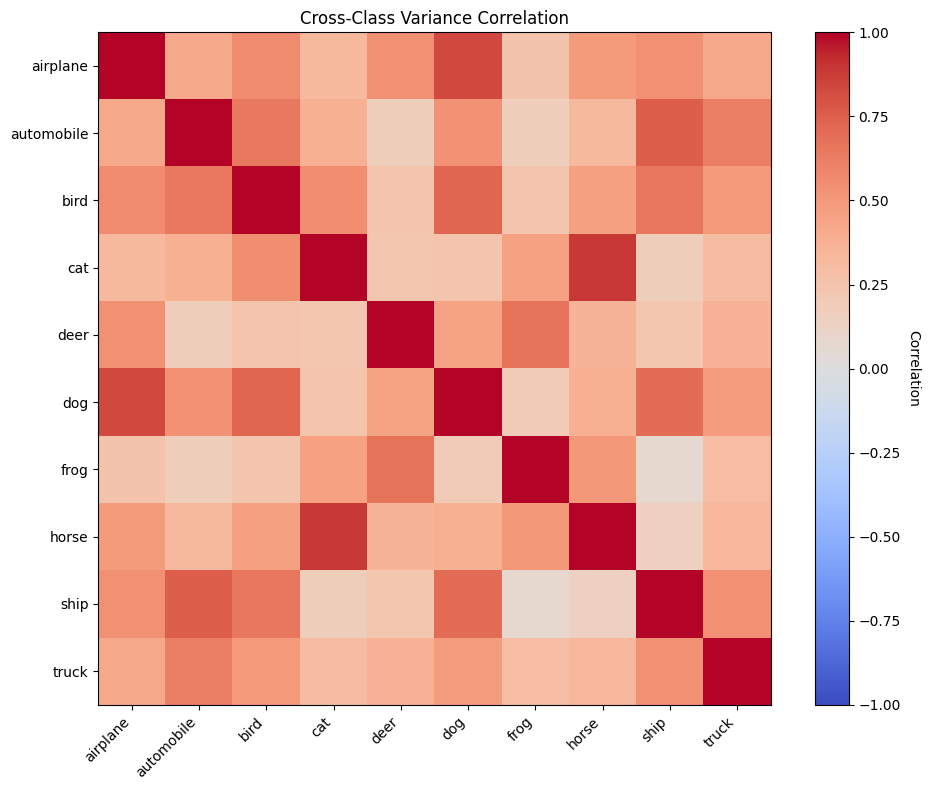

In [13]:
def cross_class_variance_correlation(v_preds_dict, class_names):
    # Convert to numpy array
    v_preds = np.stack([v_preds_dict[i] for i in v_preds_dict.keys()])

    # Remove outliers by clipping to percentile
    clip_percentile = 99.9
    cap = np.percentile(v_preds, clip_percentile)
    v_preds = np.clip(v_preds, None, cap)

    # Compute correlation matrix
    corr_matrix = np.corrcoef(v_preds.T)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")

    plt.title('Cross-Class Variance Correlation')
    plt.tight_layout()
    plt.show()

# Usage
cross_class_variance_correlation(v_preds, class_names)

In [14]:
# Get images with more than 2 classes with mA > 0.3
remax_indices = []
for i in range(len(m_preds)):
    mA, sA = remax(m_preds[i], v_preds[i])
    if np.sum(mA > 0.3) > 2:
        remax_indices.append(i)
print("REMAX indices with more than 2 classes with mA > 0.3:", remax_indices)


REMAX indices with more than 2 classes with mA > 0.3: []


## Calibration

In [15]:
import numpy as np

num_nan = sum(np.isnan(np.array(v)).any() for v in m_preds.values())
num_inf = sum(np.isinf(np.array(v)).any() for v in m_preds.values())
print(f"NaN in m_preds: {num_nan}, Inf in m_preds: {num_inf}")

def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / e_x.sum()

# Apply to each m_pred in m_preds dictionary
m_softmax = {
    k: softmax(np.array(v)) for k, v in m_preds.items()
}

y_true_list = []
confidences = []
predicted_labels = []

for k in m_softmax:
    probs = m_softmax[k]
    confidence = np.max(probs)
    pred_label = np.argmax(probs)
    true_label = y_true[k]

    confidences.append(confidence)
    predicted_labels.append(pred_label)
    y_true_list.append(true_label)

def compute_ece(y_true, y_pred, confs, num_bins=10):
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    ece = 0.0
    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = [(y_t, y_p, c) for y_t, y_p, c in zip(y_true, y_pred, confs)
                  if bin_lower < c <= bin_upper]
        if len(in_bin) == 0:
            continue
        acc = np.mean([y_t == y_p for y_t, y_p, _ in in_bin])
        conf = np.mean([c for _, _, c in in_bin])
        ece += (len(in_bin) / len(y_true)) * abs(acc - conf)
    return ece

ece_score = compute_ece(y_true_list, predicted_labels, confidences)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

NaN in m_preds: 0, Inf in m_preds: 0
Expected Calibration Error (ECE): 0.0894


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reliability_diagram(y_true, y_pred, confs, num_bins=10):
    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2

    accuracies = []
    avg_confs = []
    counts = []

    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]

        # Select data in bin
        in_bin = [(y_t, y_p, c) for y_t, y_p, c in zip(y_true, y_pred, confs)
                  if bin_lower < c <= bin_upper]

        count = len(in_bin)
        if count > 0:
            acc = np.mean([y_t == y_p for y_t, y_p, _ in in_bin])
            avg_conf = np.mean([c for _, _, c in in_bin])
        else:
            acc = 0.0
            avg_conf = 0.0

        accuracies.append(acc)
        avg_confs.append(avg_conf)
        counts.append(count)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.bar(bin_centers, accuracies, width=0.09, edgecolor='black', label='Actual Accuracy')
    plt.plot(bin_centers, avg_confs, 'o-', color='red', label='Avg Confidence')

    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

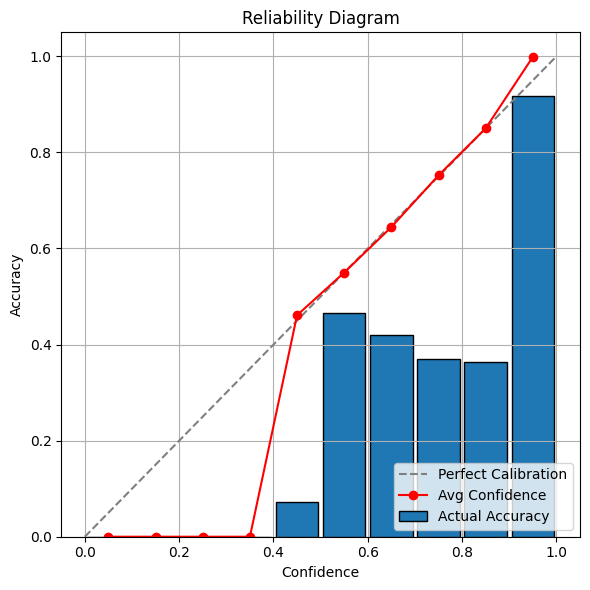

In [17]:
# You should already have these from previous steps
# y_true_list, predicted_labels, confidences

plot_reliability_diagram(y_true_list, predicted_labels, confidences)

In [18]:
y_true_list = []
confidences = []
predicted_labels = []

# Precompute Remax outputs
mA, s2A = compute_remax_for_all(m_preds, v_preds)

for k in mA:
    probs = np.array(mA[k])
    confidence = np.max(probs)
    pred_label = np.argmax(probs)
    true_label = y_true[k]

    confidences.append(confidence)
    predicted_labels.append(pred_label)
    y_true_list.append(true_label)

ece_score = compute_ece(y_true_list, predicted_labels, confidences)
print(f"Expected Calibration Error (ECE) using Remax: {ece_score:.4f}")

Expected Calibration Error (ECE) using Remax: 0.0322


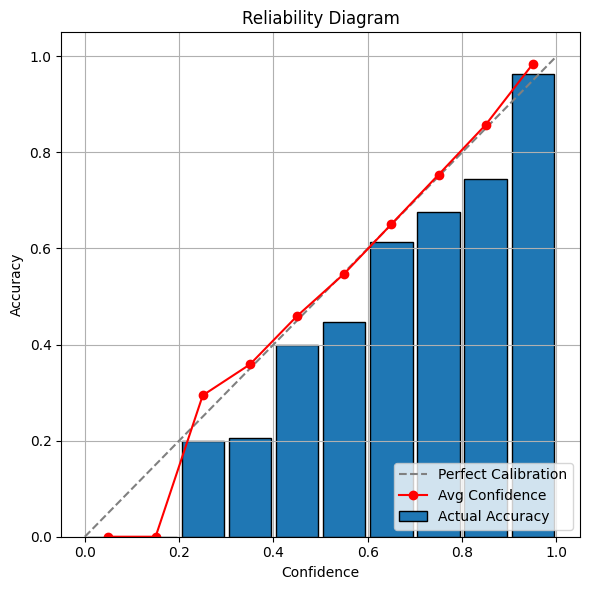

Number of predictions with confidence ≤ 0.3: 5


In [19]:
plot_reliability_diagram(y_true_list, predicted_labels, confidences)
low_conf = [c for c in confidences if c <= 0.3]
print(f"Number of predictions with confidence ≤ 0.3: {len(low_conf)}")

## Full probability calibration

Takes into considertation all the classes

In [20]:
import numpy as np

def multiclass_ece(probs_dict, y_true_dict, num_classes=10, num_bins=10):
    """
    Computes full probability calibration (MCECE) across all classes.

    Parameters:
    - probs_dict: dict[int -> np.array], predicted probabilities (softmax or remax) per sample
    - y_true_dict: dict[int -> int], true labels
    - num_classes: int, number of classes
    - num_bins: int, number of bins for confidence

    Returns:
    - ece: float, multiclass expected calibration error
    """
    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)
    total = 0
    ece = 0.0

    for i in probs_dict:
        probs = np.array(probs_dict[i])
        true_label = y_true_dict[i]

        for c in range(num_classes):
            conf = probs[c]
            correct = 1.0 if c == true_label else 0.0
            total += 1

            # Find the bin this confidence falls into
            for b in range(num_bins):
                if bin_edges[b] < conf <= bin_edges[b + 1]:
                    bin_center = (bin_edges[b] + bin_edges[b + 1]) / 2.0
                    if 'bin_data' not in locals():
                        bin_data = {k: [] for k in range(num_bins)}
                    bin_data[b].append((conf, correct))
                    break

    # Aggregate bin statistics
    for b in range(num_bins):
        bin_samples = bin_data.get(b, [])
        if len(bin_samples) == 0:
            continue
        bin_confs, bin_corrects = zip(*bin_samples)
        avg_conf = np.mean(bin_confs)
        avg_acc = np.mean(bin_corrects)
        bin_weight = len(bin_samples) / total
        ece += bin_weight * abs(avg_conf - avg_acc)

    return ece

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_calibration(probs_dict, y_true_dict, num_classes=10, num_bins=10):
    """
    Plots a multiclass reliability diagram using all class probabilities.

    Parameters:
    - probs_dict: dict[int -> np.array], predicted probabilities per sample
    - y_true_dict: dict[int -> int], true labels
    """
    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_data = {b: [] for b in range(num_bins)}

    total = 0

    for i in probs_dict:
        probs = np.array(probs_dict[i])
        true_label = y_true_dict[i]
        for c in range(num_classes):
            conf = probs[c]
            correct = 1.0 if c == true_label else 0.0
            total += 1
            for b in range(num_bins):
                if bin_edges[b] < conf <= bin_edges[b + 1]:
                    bin_data[b].append((conf, correct))
                    break

    accuracies = []
    avg_confs = []
    counts = []

    for b in range(num_bins):
        entries = bin_data[b]
        if entries:
            confs, corrects = zip(*entries)
            accuracies.append(np.mean(corrects))
            avg_confs.append(np.mean(confs))
            counts.append(len(entries))
        else:
            accuracies.append(0.0)
            avg_confs.append(0.0)
            counts.append(0)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.bar(bin_centers, accuracies, width=1.0/num_bins - 0.01, edgecolor='black',
            color='cornflowerblue', label='Actual Accuracy')
    plt.plot(bin_centers, avg_confs, 'o-', color='red', label='Avg Confidence')

    for i, count in enumerate(counts):
        if count > 0:
            plt.text(bin_centers[i], accuracies[i] + 0.03, str(count),
                     ha='center', fontsize=8, color='black')

    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Multiclass Reliability Diagram (All Classes)")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
m_softmax = {k: softmax(np.array(v)) for k, v in m_preds.items()}
ece_all = multiclass_ece(m_softmax, y_true)
print(f"Multiclass ECE (softmax): {ece_all:.4f}")

Multiclass ECE (softmax): 0.0179


In [23]:
mA, _ = compute_remax_for_all(m_preds, v_preds)
ece_all_remax = multiclass_ece(mA, y_true)
print(f"Multiclass ECE (remax): {ece_all_remax:.4f}")

Multiclass ECE (remax): 0.0039


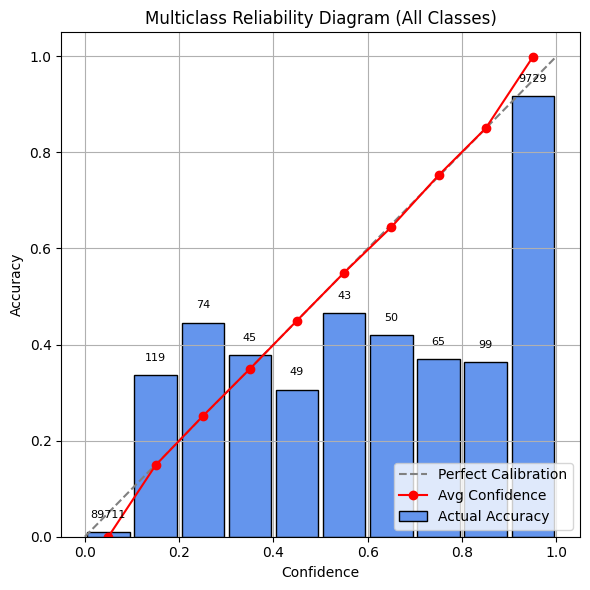

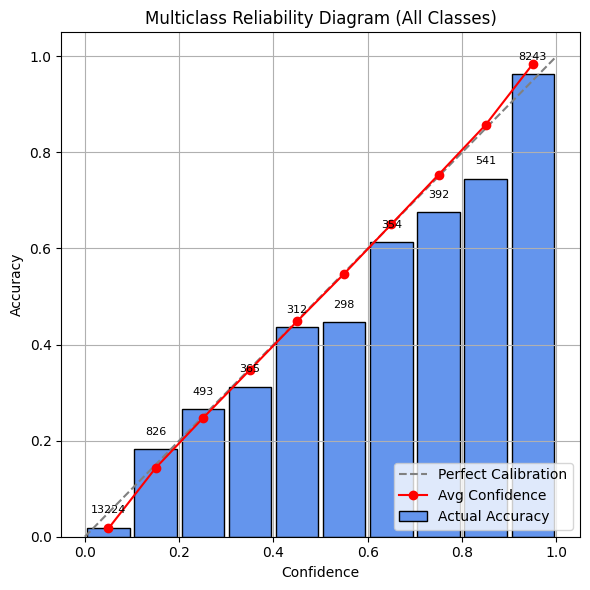

In [24]:
# For softmax-based calibration:
plot_multiclass_calibration(m_softmax, y_true, num_classes=10, num_bins=10)

# Or for Remax:
plot_multiclass_calibration(mA, y_true, num_classes=10, num_bins=10)

In [25]:
import numpy as np

def scale_logits_variance(m_preds, v_preds, alpha, beta):
    """
    Applies a linear transformation to m_preds and v_preds:
    m' = α * m + β
    v' = α² * v
    """
    m_scaled = {}
    v_scaled = {}

    for i in m_preds:
        m = np.array(m_preds[i])
        v = np.array(v_preds[i])
        m_scaled[i] = alpha * m + beta
        v_scaled[i] = (alpha ** 2) * v

    return m_scaled, v_scaled

In [26]:
import itertools

alphas = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
betas  = [2.5, 3.0, 3.5, 4.0, 4.5]

new_scales = list(itertools.product(alphas, betas))

results = []

for alpha, beta in new_scales:
    m_scaled, v_scaled = scale_logits_variance(m_preds, v_preds, alpha, beta)
    mA_scaled, _ = compute_remax_for_all(m_scaled, v_scaled)
    ece = multiclass_ece(mA_scaled, y_true)
    results.append((alpha, beta, ece))
    print(f"Scale α={alpha:.2f}, β={beta:.2f} → Multiclass ECE = {ece:.4f}")

Scale α=0.80, β=2.50 → Multiclass ECE = 0.0994
Scale α=0.80, β=3.00 → Multiclass ECE = 0.1077
Scale α=0.80, β=3.50 → Multiclass ECE = 0.1141
Scale α=0.80, β=4.00 → Multiclass ECE = 0.1192
Scale α=0.80, β=4.50 → Multiclass ECE = 0.1234
Scale α=0.90, β=2.50 → Multiclass ECE = 0.0937
Scale α=0.90, β=3.00 → Multiclass ECE = 0.1024
Scale α=0.90, β=3.50 → Multiclass ECE = 0.1092
Scale α=0.90, β=4.00 → Multiclass ECE = 0.1147
Scale α=0.90, β=4.50 → Multiclass ECE = 0.1192
Scale α=1.00, β=2.50 → Multiclass ECE = 0.0885
Scale α=1.00, β=3.00 → Multiclass ECE = 0.0975
Scale α=1.00, β=3.50 → Multiclass ECE = 0.1046
Scale α=1.00, β=4.00 → Multiclass ECE = 0.1104
Scale α=1.00, β=4.50 → Multiclass ECE = 0.1152
Scale α=1.10, β=2.50 → Multiclass ECE = 0.0835
Scale α=1.10, β=3.00 → Multiclass ECE = 0.0928
Scale α=1.10, β=3.50 → Multiclass ECE = 0.1003
Scale α=1.10, β=4.00 → Multiclass ECE = 0.1063
Scale α=1.10, β=4.50 → Multiclass ECE = 0.1114
Scale α=1.20, β=2.50 → Multiclass ECE = 0.0789
Scale α=1.20,


Best ECE: 0.0667 with α=1.5, β=2.5


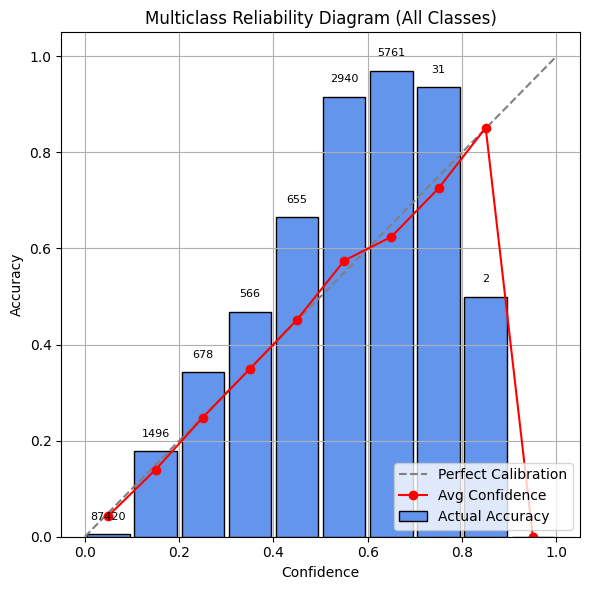

In [27]:
# Find best ECE
best_alpha, best_beta, best_ece = min(results, key=lambda x: x[2])
print(f"\nBest ECE: {best_ece:.4f} with α={best_alpha}, β={best_beta}")

# Recompute and plot
m_scaled, v_scaled = scale_logits_variance(m_preds, v_preds, best_alpha, best_beta)
mA_scaled, _ = compute_remax_for_all(m_scaled, v_scaled)
plot_multiclass_calibration(mA_scaled, y_true, num_classes=10, num_bins=10)

In [28]:
def compute_accuracy_from_probs(probs_dict, y_true_dict):
    """
    Computes overall classification accuracy from predicted probability distributions.

    Parameters:
    - probs_dict: dict[int -> np.array], probability vector per sample (from softmax or remax)
    - y_true_dict: dict[int -> int], true labels

    Returns:
    - accuracy: float, overall classification accuracy
    """
    correct = 0
    total = 0

    for i in probs_dict:
        pred_label = np.argmax(probs_dict[i])
        true_label = y_true_dict[i]
        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total

In [29]:
acc_logits = compute_accuracy_from_probs(m_preds, y_true)
print(f"Accuracy (Logits): {acc_logits:.4f}")
mA, _ = compute_remax_for_all(m_preds, v_preds)
acc = compute_accuracy_from_probs(mA, y_true)
print(f"Accuracy (Remax unscaled): {acc:.4f}")
m_scaled, v_scaled = scale_logits_variance(m_preds, v_preds, alpha=1.3, beta=3.5)
mA_scaled, _ = compute_remax_for_all(m_scaled, v_scaled)
acc_scaled = compute_accuracy_from_probs(mA_scaled, y_true)
print(f"Accuracy (Remax scaled): {acc_scaled:.4f}")

Accuracy (Logits): 0.9019
Accuracy (Remax unscaled): 0.9019
Accuracy (Remax scaled): 0.9019


The **Spearman correlation coefficient** (ρ) measures the strength and direction of the **monotonic relationship** (not necessarily linear) between two variables. It is computed as:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Where:  
- $d_i = \text{rank}(x_i) - \text{rank}(y_i)$ (difference in ranks for paired observations),  
- $n = \text{number of data points}$.  

### **What it does**:  
1. **Ranks** the data for each variable.  
2. Measures how well the relationship between variables can be described by a **monotonic function** (consistently increasing/decreasing, but not necessarily linear).  
3. Values range from **-1 to 1**:  
   - $ \rho = 1 $: Perfect increasing monotonic relationship.  
   - $ \rho = -1 $: Perfect decreasing monotonic relationship.  
   - $ \rho = 0 $: No monotonic relationship.  

### **Key difference from Pearson**:  
Pearson measures **linear** relationships; Spearman captures **any monotonic trend**.  
Example: If $y$ increases exponentially with $x$, Pearson may miss it, but Spearman will detect the monotonicity.